### MLP Digging Deeper (Pun totally intended)

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

**Load Data**

In [17]:

words = open('names.txt').read().splitlines()
print(f"Lenth: {len(words)} | Data Sample: {words[:4]}")

# Build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos.keys())

# Build dataset
BLOCK_SIZE = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # %80
Xdev, Ydev = build_dataset(words[n1:n2]) # %10
Xte, Yte = build_dataset(words[n2:]) # %10

Lenth: 32033 | Data Sample: ['emma', 'olivia', 'ava', 'isabella']
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


**Linear Layer**

In [18]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a runnning 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = xmean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # normalize to unit variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [19]:
# Use the classes to build the network
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2146483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * BLOCK_SIZE, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # apply gain to all others
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
        
    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print(sum(p.nelement() for p in parameters)) # number of total params
for p in parameters:
    p.requires_grad = True

46497


In [20]:

# ----------------------- Set Vars ----------------------- #
max_steps = 200_000
batch_size = 32 
lossi = []

# ----------------------- Train ----------------------- #
for i in range(max_steps):
    # Construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # "concat" vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01  # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Stats
    if i % 10000 == 0: # print every so often
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2814


Text(0.5, 1.0, 'Activation distribution')

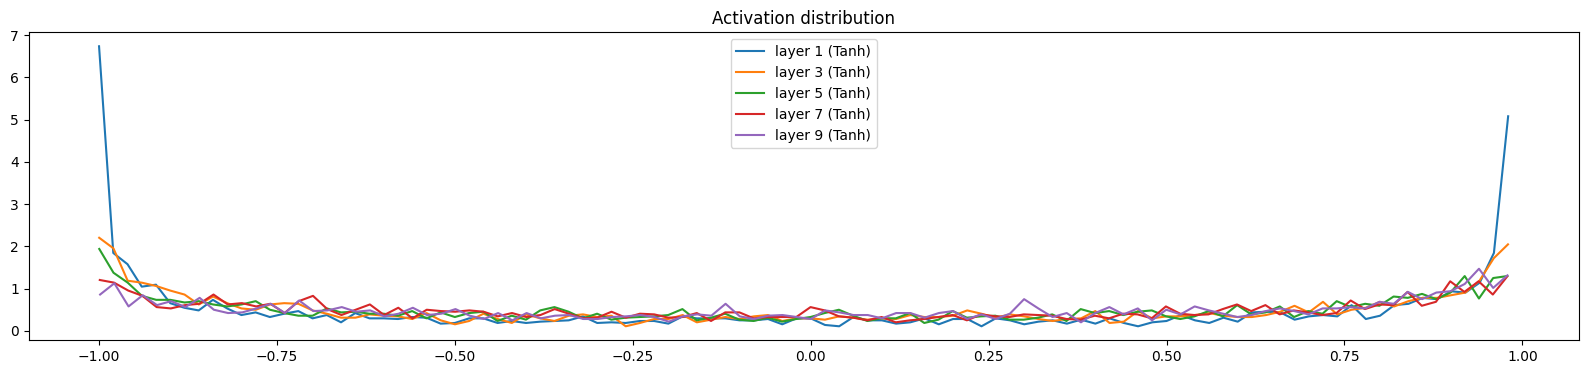

In [22]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
    # print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')